In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os 
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu
from tqdm.notebook import tqdm
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace

In [3]:
def get_ds(path):
    return pd.read_csv(path)        

In [4]:
path = '../input/bccd-dataset/BCCD_Dataset-master/test.csv'
ds=get_ds(path)
ds['cell_type_num'] = pd.factorize(ds['cell_type'])[0]


In [5]:
def callback_boxes(arg):
    return np.vstack([arg[col_name].values for col_name in ('xmin', 'xmax', 'ymin', 'ymax')]).T

def convert_to_coco(arg):
    coord_array = callback_boxes(arg)
    #print('coords',coord_array)
    x = coord_array[:,0]
    y = coord_array[:,2]
    w = coord_array[:,1] - coord_array[:,0]
    h = coord_array[:,3] - coord_array[:,2]
    return np.vstack([x,y,w,h]).T

def callback_classes(arg):
    return arg['cell_type_num'].values
    
boxes = ds.groupby(by='filename').apply(convert_to_coco)
classes = ds.groupby(by='filename').apply(callback_classes)
#print(boxes['BloodImage_00000.jpg'])


def load_image_and_labels(image_id, labels,classes, new_size):       
    image = Image.open('../input/bccd-dataset/BCCD_Dataset-master/BCCD/JPEGImages/' + image_id)
    
    width, height = image.size
    image = image.resize((new_size, new_size))
    
    label = labels[image_id].copy()
    label[:,0] = label[:,0] / (width / new_size)
    label[:,1] = label[:,1] / (height / new_size)
    label[:,2] = label[:,2] / (width / new_size)
    label[:,3] = label[:,3] / (height / new_size)
    #print(label)
    
    numerical_classes = classes[image_id]
    return np.asarray(image), label, numerical_classes

In [6]:
train_image_ids, val_image_ids = train_test_split(np.unique(boxes.index.values), 
                                                  test_size=0.1, random_state=42)

In [7]:
@dataclass
class image_size:
    new_size: int
        
        
image_params = image_size(new_size=256)
print(image_params.new_size)

256


In [8]:
import cv2, os
from matplotlib import patches, text, patheffects
def visualize_input(im, b):
    fig, ax = plt.subplots()
    ax.xaxis.tick_top()
    ax.imshow(im)
    for i in b:
        x,y,w,h=i
        ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))
    return

In [9]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_ids, batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        batch_ids = [self.image_ids[i] for i in indexes]

        X, y = self.__data_generation(batch_ids)

        return X, y
        
        
    def __data_generation(self, batch_ids):
        X, y = [], []
        
        for i, image_id in enumerate(batch_ids):
            image, bboxes, bbox_labels = load_image_and_labels(image_id, boxes,classes, image_params.new_size)
            #visualize_input(image, bboxes)
        
            augmenter = Augmentations(augment = self.augment)
            try:
                transformed_image,transformed_bboxes,transformed_labels = augmenter.augment_image_if_needed(
                    image=image, bboxes=bboxes, labels=bbox_labels)  
            except:
                print("Invalid transformation",image_id)
                transformed_image,transformed_bboxes,transformed_labels = image, bboxes, bbox_labels
            
            #transformed_image,transformed_bboxes,transformed_labels = augmenter.augment_image_if_needed(
                #image=image, bboxes=bboxes, labels=bbox_labels)    
            normalized_image = normalize(transformed_image)
            
            #visualize_input(transformed_image,transformed_bboxes)
            
            bboxes_objects = convert_from_albu1(transformed_bboxes, image_grid_object, transformed_labels)
            
            grid_creator = form_label_grid(image_grid_object)
            yolo_bboxes = grid_creator.construct_grid(bboxes_objects)
        
            X.append(normalized_image)
            y.append(yolo_bboxes)
    
        return np.array(X), np.array(y)
        
        
    
    
    
    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))

        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [10]:
def normalize(image):
    return image / 255
    

class Augmentations:
    def __init__(self, augment):
        self.augment = augment
    def clahe_to_grey(self, image, bboxes, labels):
        compose_function = albu.Compose([
            albu.CLAHE(p=1),
            albu.ToGray(p=1),])       
        return compose_function(image=image, bboxes=bboxes, labels=labels)


    def augment_image_if_needed(self, image, bboxes, labels):
        aug_res = self.clahe_to_grey(image, bboxes, labels)
        if self.augment:
            aug_res = self.make_augment(aug_res['image'], aug_res['bboxes'], aug_res['labels'])
        return np.array(aug_res['image']), aug_res['bboxes'], aug_res['labels']  
        
        
    def make_augment(self, image, bboxes, labels):
        compose_function = albu.Compose([
        albu.RandomSizedCrop(
            min_max_height=(200, 200), 
            height=image_params.new_size, 
            width=image_params.new_size, 
            p=0.8
        ),
        albu.OneOf([
            albu.Flip(),
            albu.RandomRotate90(),
        ], p=1),
        albu.OneOf([
            albu.HueSaturationValue(),
            albu.RandomBrightnessContrast()
        ], p=1),
        albu.OneOf([
            albu.GaussNoise(),
            albu.GlassBlur(),
            albu.ISONoise(),
            albu.MultiplicativeNoise(),
        ], p=0.5),
        albu.Cutout(
            num_holes=8, 
            max_h_size=16, 
            max_w_size=16, 
            fill_value=0, 
            p=0.5
        ),
        albu.CLAHE(p=1),
        albu.ToGray(p=1),
    ], 
        bbox_params={'format': 'coco', 'label_fields': ['labels']})
        return compose_function(image=image, bboxes=bboxes, labels=labels)

In [11]:
def swap_x_y(matrix):
    coord_indices = output_layout_object.get_bbox_indx_in_anchor()
    matrix[[coord_indices[0], coord_indices[1]], :] = matrix[[coord_indices[1], coord_indices[0]], :]
    matrix[[coord_indices[2], coord_indices[3]], :] = matrix[[coord_indices[3], coord_indices[2]], :]
    return matrix

def make_class_row(matrix):
    class_labels_row=np.argmax(matrix[[output_layout_object.get_class_indx_in_anchor()],:],axis=1)
    return np.vstack([matrix,class_labels_row])
    
    

def make_matrix(predictions_to_change):
    num_of_columns = image_grid_object.num_grid*image_grid_object.num_grid
    num_of_rows = output_layout_object.indx_per_anchor()* output_layout_object.anchors
    matrix = predictions_to_change.reshape((num_of_columns, num_of_rows))
    matrix = matrix.transpose()
    temp_lists=[]
    for anchor in range(output_layout_object.anchors):
        temp_lists.append(matrix[output_layout_object.get_anchor_indx(anchor), :])
    new_matrix = np.concatenate(temp_lists,axis=1)
    new_matrix = swap_x_y(new_matrix)
    return make_class_row(new_matrix)

def get_voc_grid(output_tensor):        
        n, m = output_tensor.shape[:2]
        indices = np.transpose(np.mgrid[:n, :m], (2, 1, 0))
        #print(indices.shape, np.mgrid[:n, :m].shape)
        output_tensor_to_modify = output_tensor.copy()
        cell_width = image_grid_object.cell_width()
        image_size = image_grid_object.image_size
        for anchor_num in range(output_layout_object.anchors):
            bbox_indices = output_layout_object.get_bbox_indices_in_output_vec(anchor_num)
            left_corners = ((output_tensor_to_modify[:, :, bbox_indices[:2]] + indices) * cell_width) - image_size * 0.5 * output_tensor_to_modify[:, :, bbox_indices[2:]]
            right_corners = ((output_tensor_to_modify[:, :, bbox_indices[:2]] + indices) * cell_width) + image_size * 0.5 * output_tensor_to_modify[:, :, bbox_indices[2:]]
            output_tensor_to_modify[:, :, bbox_indices[:2]] = left_corners
            output_tensor_to_modify[:, :, bbox_indices[2:]] = right_corners
        return output_tensor_to_modify


def independent_supr_for_classes(predictions_old_format,max_output_size, iou_threshold, score_threshold):
    result_boxes = []
    predictions_voc = get_voc_grid(predictions_old_format)
    predictions = make_matrix(predictions_voc)
    for class_num in range(output_layout_object.number_of_classes):
        class_indices = np.where(predictions[-1,:] == class_num)
        scores = predictions[output_layout_object.get_score_indx_in_anchor(), class_indices].flatten()
        bboxes_pre = predictions[:, np.where(predictions[-1,:] == class_num)[0]]
        bboxes = bboxes_pre[output_layout_object.get_bbox_indx_in_anchor(), :]
        bboxes = np.transpose(bboxes.astype(np.float32))
        selected_indices = tf.image.non_max_suppression(bboxes, scores, max_output_size, iou_threshold,score_threshold)
        selected_boxes = tf.gather(bboxes, selected_indices)
        result_boxes.append(selected_boxes)
    return result_boxes
    


def process_predictions(predictions, image_ids):
    predicted_bboxes = {}
    for i, image_id in enumerate(image_ids):
        predicted_bboxes[image_id] = independent_supr_for_classes(predictions[i],max_output_size = 100, 
                                                                  iou_threshold = 0.3, score_threshold = 0.1)
    return predicted_bboxes
    


@dataclass
class image_grid:
    image_size: int
    num_grid: int
        
    def cell_width(self):
        return self.image_size/self.num_grid
    

    
image_grid_object = image_grid(image_size = image_params.new_size, num_grid = 32)


                                       
                                        
@dataclass                                        
class output_layout:
    number_of_classes: int
    anchors: int
    bbox_coords_per_anchor: int
        
        
    def indx_per_anchor(self):
        return (self.number_of_classes + self.bbox_coords_per_anchor + 1)
    
    def output_vector_dim(self):
        return (self.indx_per_anchor()*self.anchors)
        
    def get_anchor_indx(self, anchor):
        first_index = self.get_anchor_first_index(anchor)
        return np.arange(first_index, first_index + self.indx_per_anchor())    
    
    def get_class_indx_in_anchor(self):
        return 1,2,3
    
    def get_score_indx_in_anchor(self):
        return 0
    
    def get_anchor_first_index(self, anchor):
        return anchor * self.indx_per_anchor();
    
    def get_score_index_in_output_vec(self, anchor):
        return self.get_score_indx_in_anchor() + self.get_anchor_first_index(anchor)
    
    def get_bbox_indices_in_output_vec(self, anchor):
        return tf.convert_to_tensor(
            self.get_anchor_first_index(anchor) + np.array(self.get_bbox_indx_in_anchor()),
            dtype=tf.int32)
    
    def get_class_indices_in_output_vec(self, anchor):
        return self.get_anchor_first_index(anchor) + np.array(self.get_class_indx_in_anchor())
    
    def get_bbox_indx_in_anchor(self):
        return 4,5,6,7
    
    def get_class_scores(self):
        return 0
                                        
    

output_layout_object = output_layout(number_of_classes = 3,anchors = 2, bbox_coords_per_anchor = 4)


    
class bbox:
    def __init__(self, bbox, image_grid, class_label):
        self.image_grid = image_grid
        self.box_x, self.box_y, self.box_width, self.box_height = bbox        
        cell_width = self.image_grid.cell_width()
        self.yolo_box_x, self.yolo_box_y = (self.center() % cell_width) / cell_width
        self.yolo_box_width = self.box_width / self.image_grid.image_size
        self.yolo_box_height = self.box_height / self.image_grid.image_size
        self.class_label = class_label
        
        
    def center(self):
        return np.array([self.box_x + (self.box_width / 2),
                self.box_y + (self.box_height / 2)])
    
    def one_hot(self):
        return tf.one_hot(indices=self.class_label, depth=output_layout_object.number_of_classes)
    
    
        
        
class form_label_grid:
    def __init__(self, image_grid):
        self.image_grid = image_grid
        self.label_grid = np.zeros((image_grid.num_grid, image_grid.num_grid,
                                    output_layout_object.indx_per_anchor()*output_layout_object.anchors))
        
    
        

        
        
    def get_cell_with_bbox_index(self, bbox):
        """ Return indices of the cell corresponding to bbox in Coco format
        Output: numpy array of integer indices (i, j)"""
        
        return (bbox.center() // self.image_grid.cell_width()).astype(np.int32)
    
    
    def get_cell_indices(self, bboxes):
        """Return indices of the cells corresponding to bboxes in Coco format
        Input: tensor of the size (N, M, 4)
        Output: tensor of the size of integer indices (N, M, 2)"""
        
        centers = np.dstack((bboxes[:, :, 0], bboxes[:, :, 2]))
        return (centers // self.image_grid.cell_width()).astype(np.int32)
    
    
    
    
            
            
    def process_bbox(self,bbox):
        cell_y, cell_x  = self.get_cell_with_bbox_index(bbox)
        output_vector = np.zeros((output_layout_object.indx_per_anchor()))
        output_vector[output_layout_object.get_score_indx_in_anchor()] = 1
        output_vector[[output_layout_object.get_class_indx_in_anchor()]] = bbox.one_hot()
        
        #debug_visualize_box(bbox.yolo_box_x,bbox.yolo_box_y, bbox.yolo_box_width, bbox.yolo_box_height)
        output_vector[[output_layout_object.get_bbox_indx_in_anchor()]] = bbox.yolo_box_x,bbox.yolo_box_y, bbox.yolo_box_width, bbox.yolo_box_height
        
        
        
        for anchor in range(output_layout_object.anchors):
            score_index = output_layout_object.get_score_index_in_output_vec(anchor)
            #print('debug', cell_x, cell_y, score_index)
            if self.label_grid[cell_x, cell_y, score_index] == 0:
                self.label_grid[cell_x, cell_y, output_layout_object.get_anchor_indx(anchor)] = output_vector
                break


    
    def construct_grid(self, bboxes):
        for bbox in bboxes:
            self.process_bbox(bbox)
        return self.label_grid  
        
            



def convert_from_albu1(bboxes, grid_params, class_label):
    res=[]
    for i in range(len(bboxes)):
        res.append(bbox(bboxes[i], grid_params, class_label[i]))
    return res



In [12]:
index = np.argwhere(train_image_ids=='BloodImage_00338.jpg')
train_image_ids = np.delete(train_image_ids, index)

index = np.argwhere(train_image_ids=='BloodImage_00343.jpg')
train_image_ids = np.delete(train_image_ids, index)

In [ ]:
'''train_generator = DataGenerator(
    train_image_ids,
    batch_size=4, 
    shuffle=True,
    augment=True
)

#dir(train_generator)
a=train_generator._DataGenerator__data_generation(['BloodImage_00038.jpg'])'''

In [13]:
train_generator = DataGenerator(
    train_image_ids,
    batch_size=6, 
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    val_image_ids, 
    batch_size=10,
    shuffle=False,
    augment=False
)


In [14]:
# Download Ngrok to tunnel the tensorboard port to an external port
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
import os
import multiprocessing


pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir ./logs/ --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]

--2021-08-22 13:39:03--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.4.53.8, 107.23.196.66, 52.0.235.238, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.4.53.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  16.4MB/s    in 0.8s    

2021-08-22 13:39:05 (16.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [15]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://ab95-34-127-5-193.ngrok.io


In [16]:
import datetime 
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
def custom_loss(y_true, y_pred):
    #set_trace()
    
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,output_layout_object.get_score_index_in_output_vec(anchor=0)],\
                   y_true[:,:,:,output_layout_object.get_score_index_in_output_vec(anchor=1)]], axis=0), 
        tf.concat([y_pred[:,:,:,output_layout_object.get_score_index_in_output_vec(anchor=0)], \
                   y_pred[:,:,:,output_layout_object.get_score_index_in_output_vec(anchor=1)]], axis=0)
    )
    
    ind_class0 = output_layout_object.get_class_indices_in_output_vec(anchor=0)
    ind_class1 = output_layout_object.get_class_indices_in_output_vec(anchor=1)
    class_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,ind_class0[0]:ind_class0[2]+1],\
                   y_true[:,:,:,ind_class1[0]:ind_class1[2]+1]], axis=0), 
        tf.concat([y_pred[:,:,:,ind_class0[0]:ind_class0[2]+1], \
                   y_pred[:,:,:,ind_class1[0]:ind_class1[2]+1]], axis=0)
    )
    
    ind0 = output_layout_object.get_bbox_indices_in_output_vec(anchor=0)
    ind1 = output_layout_object.get_bbox_indices_in_output_vec(anchor=1)
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,ind0[0]:ind0[2]], \
                   y_true[:,:,:,ind1[0]:ind1[2]]], axis=0), 
        tf.concat([y_pred[:,:,:,ind0[0]:ind0[2]], \
                   y_pred[:,:,:,ind1[0]:ind1[2]]], axis=0)
    )
    
    
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,ind0[2]:ind0[3]+1], \
                   y_true[:,:,:,ind1[2]:ind1[3]+1]], axis=0), 
        tf.concat([y_pred[:,:,:,ind0[2]:ind0[3]+1], \
                   y_pred[:,:,:,ind1[2]:ind1[3]+1]], axis=0)
    )
    
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + class_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,output_layout_object.get_score_index_in_output_vec(anchor=0)] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,output_layout_object.get_score_index_in_output_vec(anchor=1)] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [18]:
x_input = tf.keras.Input(shape=(image_params.new_size,image_params.new_size,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(4):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(output_layout_object.output_vector_dim(), (1, 1), strides=(1, 1), activation='sigmoid')(x)

model = tf.keras.Model(inputs=x_input, outputs=predictions)

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=80,
    callbacks=[callbacks,tensorboard_callback]
)

In [20]:
val_generator = DataGenerator(
    val_image_ids, 
    batch_size=1,
    shuffle=False,
    augment=False
)
val_predictions = model.predict(val_generator)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [21]:
val_predictions_modified = process_predictions(val_predictions, val_image_ids)

In [ ]:
np.save('yolo_bccd_predictions', val_predictions)

In [ ]:
model.save_weights('yolo_bccd')

In [19]:
model.load_weights('../input/notebookf4b56c2c3f/yolo_bccd')

In [ ]:
def draw_bboxes(image_id, bboxes, source='train'):  
    image = Image.open('../input/bccd-dataset/BCCD_Dataset-master/BCCD/JPEGImages/' + image_id)
    image = image.resize((image_params.new_size,image_params.new_size))
    
    draw = ImageDraw.Draw(image)
    print(bboxes)       
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)


def draw_bbox(draw, bbox):
    y1, x1, y2, x2 = bbox
    draw.rectangle([x1, y1, x2, y2], width=2, outline='red')

In [ ]:
def show_images(image_ids, bboxes, source='train'):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id][0], source)
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5 * num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

In [ ]:
#show_images(val_image_ids[1:3], val_predictions_modified)

In [ ]:
print('Epochs: ' + str(len(history.history['loss'])))
print('Final training loss: ' + str(history.history['loss'][-1]))
print('Final validation loss: ' + str(history.history['val_loss'][-1]))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

In [27]:
def plot_box_label(image_id, res, gr_tr):
    imagePath='../input/bccd-dataset/BCCD_Dataset-master/BCCD/JPEGImages/' + image_id
    image = cv2.imread(imagePath)
    #image = cv2.resize(image, (image_params.new_size,image_params.new_size))
    scale = 4
    image = cv2.resize(image, (1024, 1024))
    for label in range(len(res)):
        color = [(255, 0, 0), (0, 0, 255), (0, 255, 0)]
        text = ['WBC', 'RBC', 'Platelets']
        for bbox in res[label]:
            y1, x1, y2, x2 = bbox * scale
            startX, startY,endX, endY = int(x1), int(y1), int(x2), int(y2)
            #y = startY - 5 if startY - 5 > 5 else startY + 5
            y=startY
            cv2.putText(image, text[label], (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 2, color[label], 2)
            cv2.rectangle(image, (startX, startY), (endX, endY),color[label], 4)
            
    #plot_ground_tr_boxes(image,gr_tr)
    
    
    
    #print(image.shape)
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.savefig('detected'+image_id+'.png', dpi = 300)
    plt.show()
    return

In [23]:
def plot_ground_tr_boxes(image,gr_tr):
    for bbox in gr_tr:
            x1, y1, w, h = bbox
            startX, startY,endX, endY = int(x1), int(y1), int(w+x1), int(h+y1)
            cv2.rectangle(image, (startX, startY), (endX, endY),(45, 255, 255), 2)
    return
    

In [24]:
#gr_tr = load_image_and_labels(val_image_ids[1], boxes,classes, 256)[1]
#plot_box_label(val_image_ids[1],val_predictions_modified[val_image_ids[1]],gr_tr)

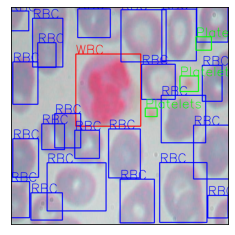

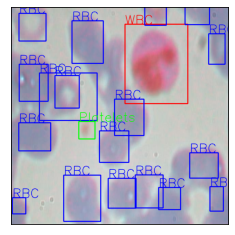

In [29]:
for i in val_image_ids[8:10]:
    #gr_tr = []
    plot_box_label(i,val_predictions_modified[i],gr_tr)
    

In [ ]:
import cv2, os
from matplotlib import patches, text, patheffects
def visualize_input(im, b):
    fig, ax = plt.subplots()
    ax.xaxis.tick_top()
    ax.imshow(im)
    for i in b:
        x,y,w,h=i
        ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))
    return

In [ ]:
#visualize_input(load_image_and_labels(val_image_ids[1], boxes,classes, 256)[0], gr_tr)